# Slippage Analysis

When evaluating a strategy using backtest results, we often want to know how sensitive it's performance is to implementation shortfall or slippage. pyfolio's transactions tear sheet can create "slippage sweep" plots that display strategy performance under various slippage assumptions. 

Additional per-dollar slippage can be applied to returns before running a tear sheet by providing `create_full_tear_sheet` with the a level of slippage in basis points (1% == 100 basis points) as the `slippage` keyword argument. The slippage plots in the transactions tear sheet will display returns with slippage added to the **unadjusted** returns. 

For example, if you run a backtest with no transaction costs and call `create_full_tear_sheet(returns, positions, transactions, slippage=5)`, 5 bps of slippage will be applied to `returns` before all plots and figures, with the exception of the slippage sweep plots, are generated.

It is important to emphasize that the slippage plots will display performance under **additional** slippage. If the passed performance data already has slippage applied, the 5 bps slippage equity curve will represent performance under 5 bps of slippage in addition to the already simulated slippage penalty. If slippage is already applied to the performance results, pass `slippage=0` to the `create_full_tear_sheet` to trigger the creation of the additional slippage sweep plots without applying any additional slippage to the returns time series used throughout the rest of the tear sheet.

In [1]:
%matplotlib inline
import pyfolio as pf
import gzip
import pandas as pd

# silence warnings
import warnings
warnings.filterwarnings('ignore')

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
transactions = pd.read_csv(gzip.open('test_data/test_txn.csv.gz'),
                    index_col=0, parse_dates=True)
positions = pd.read_csv(gzip.open('test_data/test_pos.csv.gz'),
                    index_col=0, parse_dates=True)
returns = pd.read_csv(gzip.open('test_data/test_returns.csv.gz'),
                    index_col=0, parse_dates=True, header=None)[1]
returns.index = returns.index.tz_localize("UTC")
positions.index = positions.index.tz_localize("UTC")
transactions.index = transactions.index.tz_localize("UTC")

In [14]:
transactions.tail(20)

,amount,price,sid,symbol,txn_dollars
2009-12-29 00:00:00+00:00,-16,20.932501,1,CERN,334.920016
2009-12-29 00:00:00+00:00,-60,50.954846,2,COST,3057.290760
2009-12-29 00:00:00+00:00,187,13.852460,3,DELL,-2590.410020
2009-12-29 00:00:00+00:00,547,18.953215,4,GPS,-10367.408605
2009-12-29 00:00:00+00:00,762,16.830877,5,INTC,-12825.128274
2009-12-29 00:00:00+00:00,-108,72.905033,6,MMM,7873.743564
2009-12-30 00:00:00+00:00,143,9.720000,0,AMD,-1389.960000
2009-12-30 00:00:00+00:00,-24,20.897499,1,CERN,501.539976
2009-12-30 00:00:00+00:00,276,50.777274,2,COST,-14014.527624
2009-12-30 00:00:00+00:00,6313,14.307110,3,DELL,-90320.785430


In [15]:
positions.iloc[:,:-1].sum(axis=1)

index
2004-01-09 00:00:00+00:00    106192.360298
2004-01-12 00:00:00+00:00    104189.901386
2004-01-13 00:00:00+00:00     94237.154765
2004-01-14 00:00:00+00:00    102503.607115
2004-01-15 00:00:00+00:00    101914.645342
2004-01-16 00:00:00+00:00    101661.782297
2004-01-20 00:00:00+00:00     99415.189135
2004-01-21 00:00:00+00:00    101218.387085
2004-01-22 00:00:00+00:00    101016.332328
2004-01-23 00:00:00+00:00     98567.948152
2004-01-26 00:00:00+00:00    100867.707886
2004-01-27 00:00:00+00:00    101398.100850
2004-01-28 00:00:00+00:00     94419.831040
2004-01-29 00:00:00+00:00     94920.492793
2004-01-30 00:00:00+00:00     98922.249771
2004-02-02 00:00:00+00:00     96979.065831
2004-02-03 00:00:00+00:00     98595.392084
2004-02-04 00:00:00+00:00    110426.257157
2004-02-05 00:00:00+00:00     94513.429142
2004-02-06 00:00:00+00:00     90513.466640
2004-02-09 00:00:00+00:00    109392.626530
2004-02-10 00:00:00+00:00    100264.964578
2004-02-11 00:00:00+00:00    103102.877231
2004-

In [8]:
positions.tail()

,AMD,CERN,COST,DELL,GPS,INTC,MMM,cash
index,,,,,,,,
2009-12-24 00:00:00+00:00,-1199.11,1316.857500,22778.660580,-3562.47039,76601.638113,36280.269375,17740.890304,16350.679211
2009-12-28 00:00:00+00:00,589.80,673.840032,24170.422856,-1765.41500,83143.517604,37499.607147,15692.520137,7641.201795
2009-12-29 00:00:00+00:00,292.50,334.920016,20993.396552,858.85252,94500.729990,50509.461877,7946.648597,-6583.290764
2009-12-30 00:00:00+00:00,1681.56,-167.179992,34934.764512,91207.82625,29751.588246,38052.304640,-3926.109096,-22234.787956
2009-12-31 00:00:00+00:00,22254.32,9975.240484,47781.667800,53022.51955,27393.148240,18850.582240,-1934.275491,-11938.952799


In [17]:
returns.tail()

0
2009-12-24 00:00:00+00:00   -0.001067
2009-12-28 00:00:00+00:00    0.008046
2009-12-29 00:00:00+00:00    0.007204
2009-12-30 00:00:00+00:00    0.002646
2009-12-31 00:00:00+00:00   -0.023011
Name: 1, dtype: float64

Start date,2004-01-02
End date,2009-12-31
Total months,71
,Backtest
Annual return,5.8%
Cumulative returns,40.0%
Annual volatility,26.3%
Sharpe ratio,0.35
Calmar ratio,0.09
Stability,0.09
Max drawdown,-61.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,61.55,2007-11-06,2009-03-09,NaT,NaN
1,26.17,2004-11-15,2006-09-07,2007-07-16,696
2,12.10,2004-06-25,2004-08-12,2004-11-05,96
3,9.56,2007-07-16,2007-08-06,2007-09-18,47
4,7.13,2004-04-23,2004-05-17,2004-06-07,32


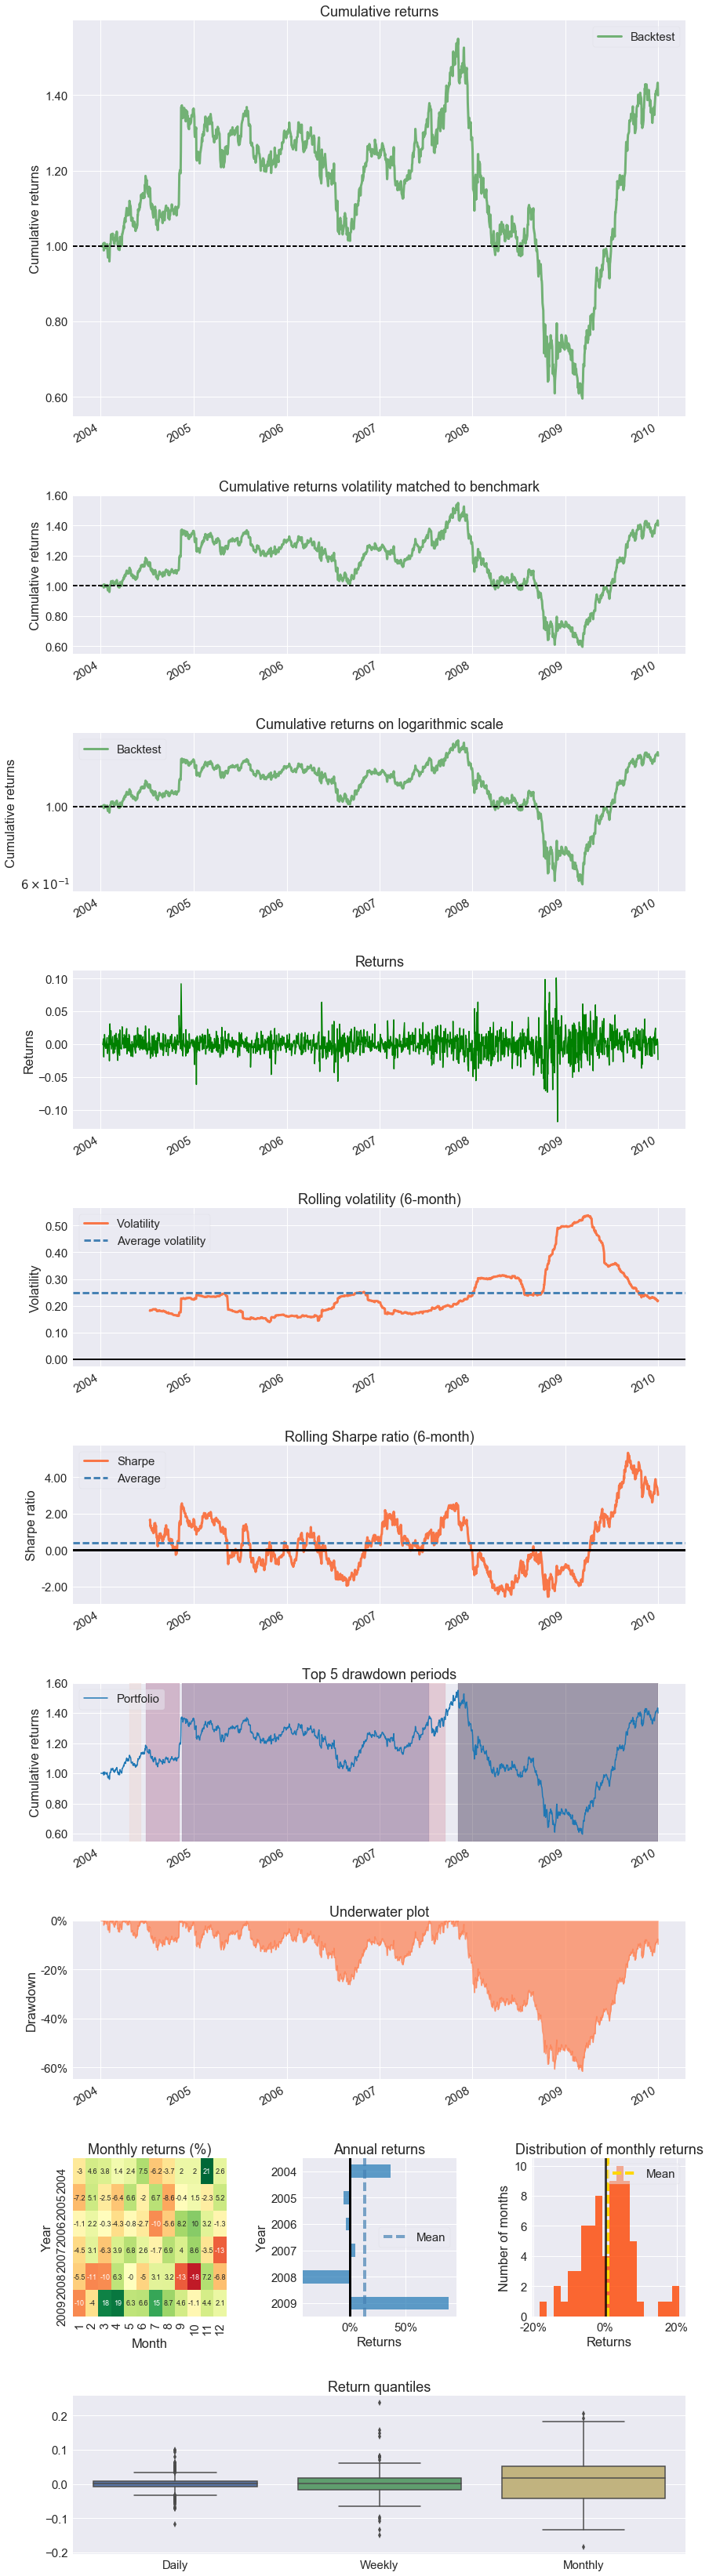

Stress Events,mean,min,max
Lehmann,-0.27%,-4.71%,4.11%
Aug07,0.30%,-2.96%,2.92%
Mar08,-0.44%,-3.27%,3.36%
Sept08,-0.69%,-4.42%,4.08%
2009Q1,-0.36%,-5.04%,3.38%
2009Q2,0.72%,-4.03%,6.13%
Low Volatility Bull Market,-0.00%,-6.12%,6.41%
GFC Crash,-0.10%,-11.79%,10.11%
Recovery,0.34%,-4.03%,6.00%


AttributeError: 'NoneType' object has no attribute 'copy'

In [16]:
pf.create_full_tear_sheet(returns, positions, transactions, slippage=5)